In [1]:
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, matthews_corrcoef, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import RidgeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer


import shap
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import dice_ml
from dice_ml.utils import helpers

/home/diego/miniconda3/envs/clustering_ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X = pd.read_csv('data/processed/X_scaled.csv')
y = pd.read_csv('data/processed/y.csv')
labels = pd.read_csv('data/clustering/labels_spectral4.csv')

In [3]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

## Classification Model

In [4]:

class CLFModels():
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.models = {
            "AdaBoost": AdaBoostClassifier(),
            "RandomForest": RandomForestClassifier(),
            "SVM": SVC(probability=True, kernel="linear"),
            "DecisionTree": DecisionTreeClassifier(),
            "LGBM": LGBMClassifier(),
            "XGBoost": XGBClassifier()
        }
        self.algorithm_colors = {
            "AdaBoost": plt.cm.Blues,
            "RandomForest": plt.cm.Greens,
            "SVM": plt.cm.Reds,
            "DecisionTree": plt.cm.Purples,
            "LGBM": plt.cm.Oranges,
            "XGBoost": plt.cm.Greys
        }

    def train(self):
        for name, model in self.models.items():
            model.fit(self.X_train, self.y_train.values.ravel())

    def cross_validate(self, cv=5):

        scoring = {
            'accuracy': 'accuracy',
            'precision': make_scorer(precision_score, average='weighted'),
            'f1': make_scorer(f1_score, average='weighted'),
            'recall': make_scorer(recall_score, average='weighted'),
            'mcc': make_scorer(matthews_corrcoef)
        }

        results = {metric: [] for metric in scoring.keys()}

        for name, model in self.models.items():
            for metric, scorer in scoring.items():
                scores = cross_val_score(model, self.X_train, self.y_train.values.ravel(), cv=cv, scoring=scorer)
                results[metric].append(scores.mean())

        return pd.DataFrame(results, index=self.models.keys())

    def get_performances(self, X_val, y_val):
        performances = []
        for name, model in self.models.items():
            y_pred = model.predict(X_val)
            performances.append([
                name,
                accuracy_score(y_true=y_val, y_pred=y_pred),
                precision_score(y_true=y_val, y_pred=y_pred, average='weighted'),
                f1_score(y_true=y_val, y_pred=y_pred, average='weighted'),
                recall_score(y_true=y_val, y_pred=y_pred, average='weighted'),
                matthews_corrcoef(y_true=y_val, y_pred=y_pred)
            ])
        
        return pd.DataFrame(performances, columns=["Model", "Accuracy", "Precision", "F1", "Recall", "MCC"])

    def plot_ROC(self, X_val, y_val):
        plt.figure(figsize=(10, 8))

        for name, model in self.models.items():
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_val)
            else:
                y_proba = model.decision_function(X_val)
            
            y_val_bin = label_binarize(y_val, classes=np.unique(y_val))
            n_classes = y_val_bin.shape[1]

            for i in range(n_classes):
                color = self.algorithm_colors[name]((i + 1) / n_classes)
                fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'{name} class {i} (AUC = {roc_auc:.2f})', color=color)

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.savefig("img/roc.png")
        plt.show()
    
    def plot_CM(self, X_val, y_val):
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
        axes = axes.flatten()

        for ax, (name, model) in zip(axes, self.models.items()):
            y_pred = model.predict(X_val)
            cm = confusion_matrix(y_val, y_pred)
            color = self.algorithm_colors.get(name, plt.cm.Blues)
            sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=color)
            ax.set_title(name)
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')

        plt.tight_layout()
        plt.savefig("img/cm.png")
        plt.show()
    
    def plot_precision_recall(self, X_val, y_val):
        plt.figure(figsize=(10, 8))

        for name, model in self.models.items():
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_val)
            else:
                y_proba = model.decision_function(X_val)
            
            y_val_bin = label_binarize(y_val, classes=np.unique(y_val))
            n_classes = y_val_bin.shape[1]

            for i in range(n_classes):
                color = self.algorithm_colors[name]((i + 1) / n_classes)
                precision, recall, _ = precision_recall_curve(y_val_bin[:, i], y_proba[:, i])
                plt.plot(recall, precision, label=f'{name} class {i}', color=color)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.savefig("img/pr.png")
        plt.show()

In [5]:
cmodels_instance = CLFModels(X_train, y_train)
cmodels_instance.train()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3287
[LightGBM] [Info] Number of data points in the train set: 1094, number of used features: 38
[LightGBM] [Info] Start training from score -1.277284
[LightGBM] [Info] Start training from score -1.508658
[LightGBM] [Info] Start training from score -1.341604
[LightGBM] [Info] Start training from score -1.433076


In [6]:
cmodels_instance.get_performances(X_val, y_val)

,Model,Accuracy,Precision,F1,Recall,MCC
0,AdaBoost,0.791971,0.793325,0.790498,0.791971,0.723456
1,RandomForest,0.864964,0.865839,0.865149,0.864964,0.820044
2,SVM,0.945255,0.945917,0.944980,0.945255,0.927275
3,DecisionTree,0.558394,0.568530,0.561304,0.558394,0.412110
4,LGBM,0.850365,0.850569,0.849653,0.850365,0.800755
5,XGBoost,0.879562,0.883431,0.880003,0.879562,0.840277


In [7]:
cmodels_instance.get_performances(X_test, y_test)

,Model,Accuracy,Precision,F1,Recall,MCC
0,AdaBoost,0.782895,0.787197,0.781465,0.782895,0.710037
1,RandomForest,0.822368,0.826796,0.821897,0.822368,0.763143
2,SVM,0.894737,0.896179,0.894657,0.894737,0.858964
3,DecisionTree,0.598684,0.608628,0.601792,0.598684,0.461973
4,LGBM,0.828947,0.832035,0.827653,0.828947,0.770634
5,XGBoost,0.796053,0.800985,0.795948,0.796053,0.727443


In [8]:
cmodels_instance.cross_validate()

/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.506366
[LightGBM] [Info] Start training from score -1.344878
[LightGBM] [Info] Start training from score -1.431890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3287
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.506366
[LightGBM] [Info] Start training from score -1.340502
[LightGBM] [Info] Start training from score -1.436686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.511534
[LightGBM] [Info] Start training from score -1.340502
[LightGBM] [Info] Start training from score -1.431890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.511534
[LightGBM] [Info] Start training from score -1.340502
[LightGBM] [Info] Start training from score -1.431890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 38
[LightGBM] [Info] Start training from score -1.278198
[LightGBM] [Info] Start training from score -1.507508
[LightGBM] [Info] Start training from score -1.341644
[LightGBM] [Info] Start training from score -1.433032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.506366
[LightGBM] [Info] Start training from score -1.344878
[LightGBM] [Info] Start training from score -1.431890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3287
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.506366
[LightGBM] [Info] Start training from score -1.340502
[LightGBM] [Info] Start training from score -1.436686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.511534
[LightGBM] [Info] Start training from score -1.340502
[LightGBM] [Info] Start training from score -1.431890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.511534
[LightGBM] [Info] Start training from score -1.340502
[LightGBM] [Info] Start training from score -1.431890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 38
[LightGBM] [Info] Start training from score -1.278198
[LightGBM] [Info] Start training from score -1.507508
[LightGBM] [Info] Start training from score -1.341644
[LightGBM] [Info] Start training from score -1.433032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.506366
[LightGBM] [Info] Start training from score -1.344878
[LightGBM] [Info] Start training from score -1.431890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3287
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.506366
[LightGBM] [Info] Start training from score -1.340502
[LightGBM] [Info] Start training from score -1.436686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.511534
[LightGBM] [Info] Start training from score -1.340502
[LightGBM] [Info] Start training from score -1.431890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.511534
[LightGBM] [Info] Start training from score -1.340502
[LightGBM] [Info] Start training from score -1.431890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 38
[LightGBM] [Info] Start training from score -1.278198
[LightGBM] [Info] Start training from score -1.507508
[LightGBM] [Info] Start training from score -1.341644
[LightGBM] [Info] Start training from score -1.433032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.506366
[LightGBM] [Info] Start training from score -1.344878
[LightGBM] [Info] Start training from score -1.431890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3287
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.506366
[LightGBM] [Info] Start training from score -1.340502
[LightGBM] [Info] Start training from score -1.436686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.511534
[LightGBM] [Info] Start training from score -1.340502
[LightGBM] [Info] Start training from score -1.431890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.511534
[LightGBM] [Info] Start training from score -1.340502
[LightGBM] [Info] Start training from score -1.431890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 38
[LightGBM] [Info] Start training from score -1.278198
[LightGBM] [Info] Start training from score -1.507508
[LightGBM] [Info] Start training from score -1.341644
[LightGBM] [Info] Start training from score -1.433032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.506366
[LightGBM] [Info] Start training from score -1.344878
[LightGBM] [Info] Start training from score -1.431890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3287
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.506366
[LightGBM] [Info] Start training from score -1.340502
[LightGBM] [Info] Start training from score -1.436686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.511534
[LightGBM] [Info] Start training from score -1.340502
[LightGBM] [Info] Start training from score -1.431890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 38
[LightGBM] [Info] Start training from score -1.277056
[LightGBM] [Info] Start training from score -1.511534
[LightGBM] [Info] Start training from score -1.340502
[LightGBM] [Info] Start training from score -1.431890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 38
[LightGBM] [Info] Start training from score -1.278198
[LightGBM] [Info] Start training from score -1.507508
[LightGBM] [Info] Start training from score -1.341644
[LightGBM] [Info] Start training from score -1.433032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/diego/miniconda3/envs/clustering_ml/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Out

AttributeError: 'super' object has no attribute '__sklearn_tags__'

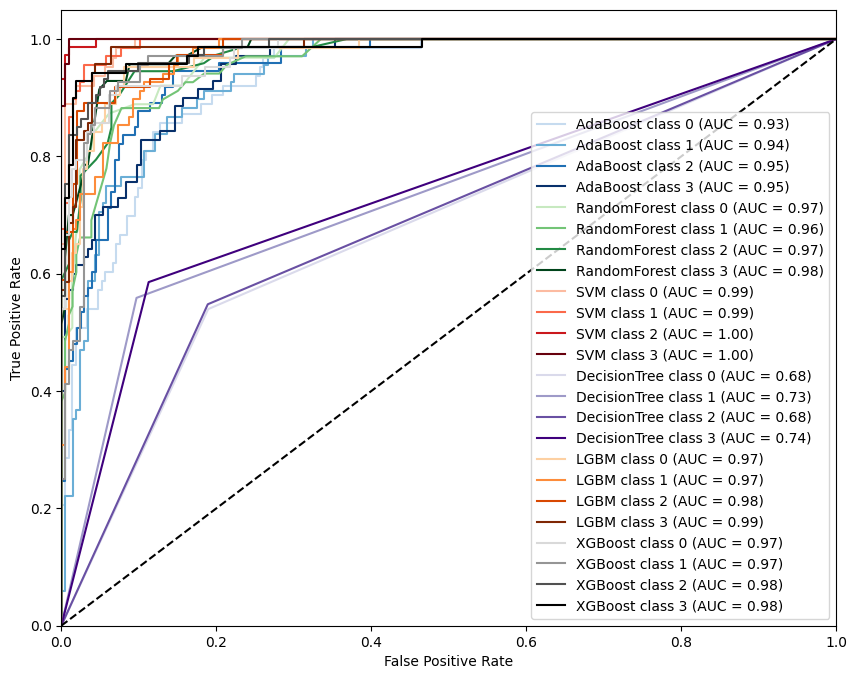

In [8]:
cmodels_instance.plot_ROC(X_val, y_val)

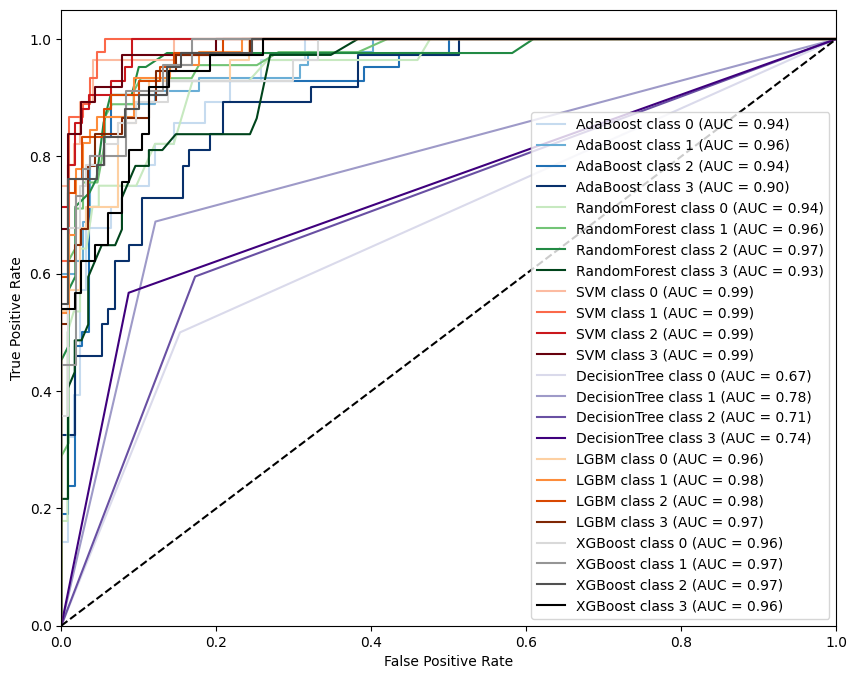

In [9]:
cmodels_instance.plot_ROC(X_test, y_test)

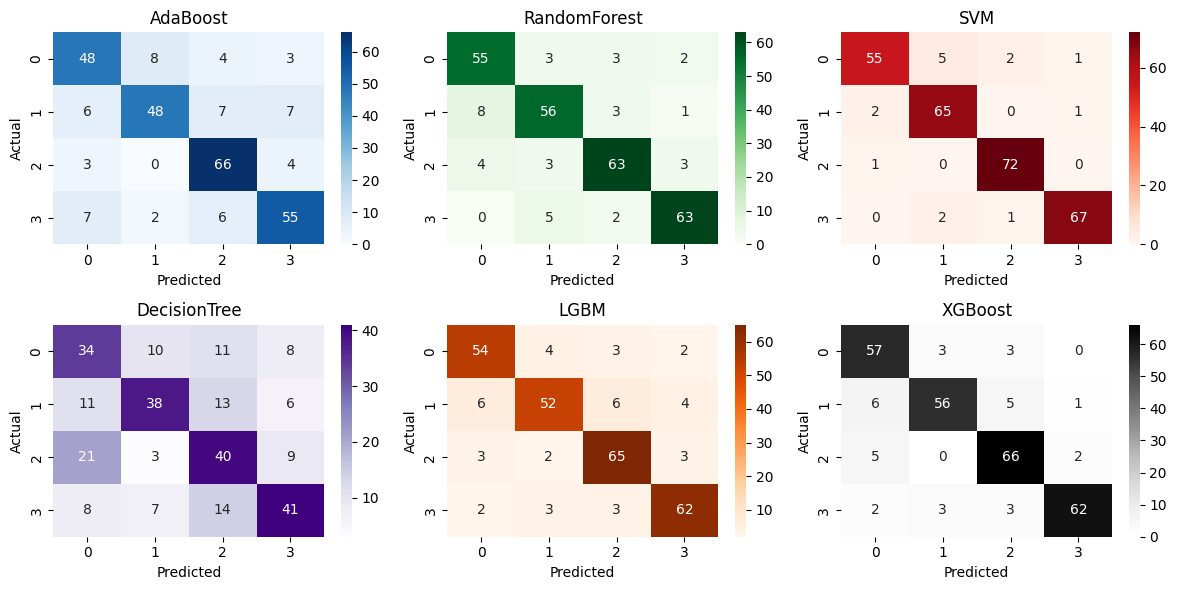

In [10]:
cmodels_instance.plot_CM(X_val, y_val)

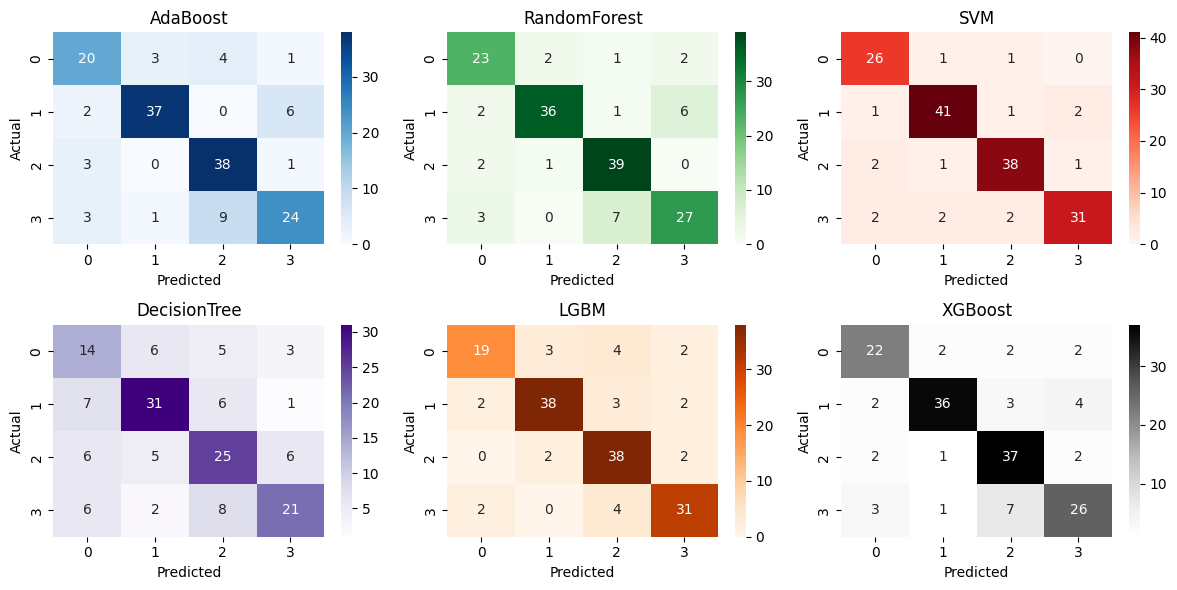

In [11]:
cmodels_instance.plot_CM(X_test, y_test)

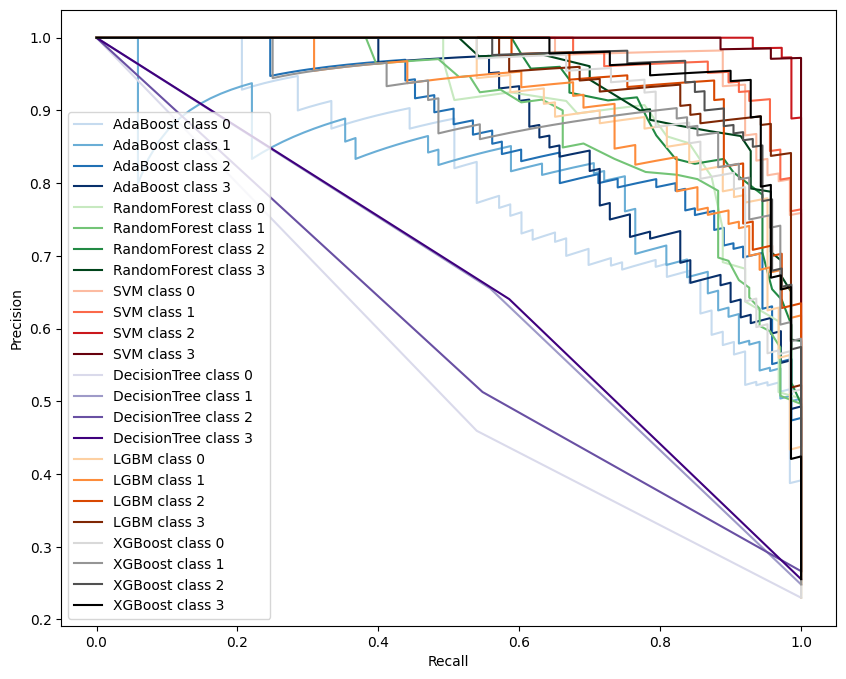

In [12]:
cmodels_instance.plot_precision_recall(X_val, y_val)

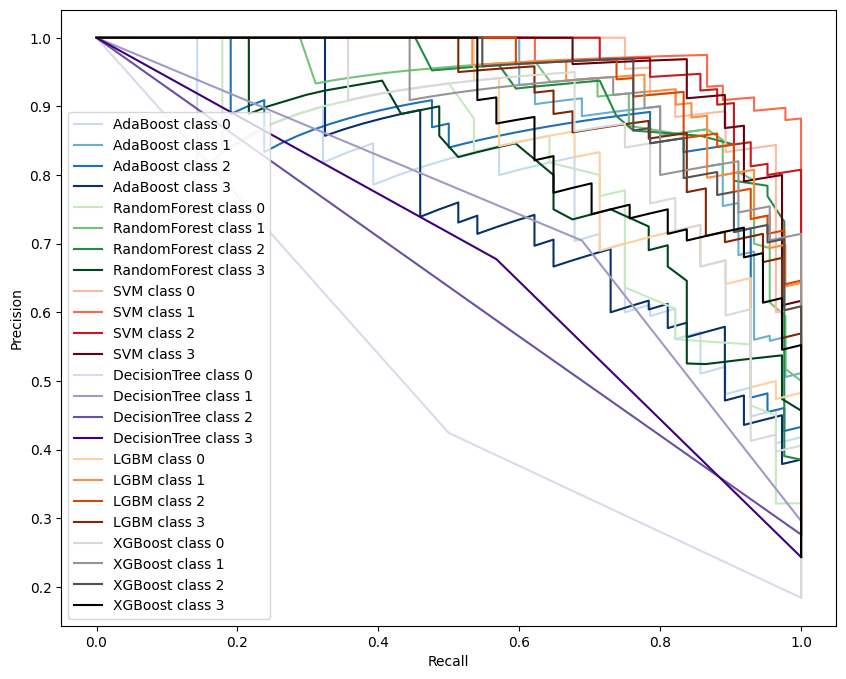

In [13]:
cmodels_instance.plot_precision_recall(X_test, y_test)

In [35]:
feature_importances = cmodels_instance.models["SVM"].coef_[0]

feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
feature_importances_df

,Feature,Importance
16,CholesterolTotal,2.443170
2,BMI,2.087200
30,Ethnicity_0,1.585375
17,CholesterolLDL,0.992657
34,EducationLevel_0,0.681714
18,CholesterolHDL,0.540126
19,CholesterolTriglycerides,0.490721
7,SleepQuality,0.390726
35,EducationLevel_1,0.353185
6,DietQuality,0.352277


## Regression Model

### Obtencion del primer grupo

In [5]:
X_sample = pd.concat([X, labels], axis=1)
X_sample = X_sample[X_sample['Cluster'] == 0]
X_sample

,Age,Gender,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,...,Forgetfulness,Ethnicity_0,Ethnicity_1,Ethnicity_2,Ethnicity_3,EducationLevel_0,EducationLevel_1,EducationLevel_2,EducationLevel_3,Cluster
6,0.4375,1,0.685179,0,-0.573113,0.332507,0.567636,0.781089,0,1,...,1,1,0,0,0,1,0,0,0,0
10,0.6250,0,0.685010,0,-0.726758,-0.160751,-0.523807,0.550437,0,0,...,0,1,0,0,0,0,1,0,0,0
13,-0.5625,0,0.794935,0,-0.770188,-0.381047,0.916523,0.852571,0,0,...,0,1,0,0,0,0,1,0,0,0
16,0.7500,0,0.461158,1,0.586436,0.941255,0.896544,0.353617,0,0,...,1,0,1,0,0,0,0,1,0,0
17,-0.4375,1,0.343518,0,-0.686188,-0.240154,-0.406381,-0.647060,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,-0.5625,1,0.776127,0,0.952319,-0.860295,0.090852,-0.219491,0,0,...,0,1,0,0,0,0,0,0,1,0
1504,0.0000,1,0.884705,1,-0.325947,0.527553,0.568057,0.925761,0,0,...,1,0,0,0,1,0,0,1,0,0
1507,-0.6250,0,-0.109690,0,-0.004021,1.025417,0.534376,-0.670296,1,0,...,0,1,0,0,0,0,0,1,0,0
1512,-0.8125,1,0.029799,1,-0.216714,-0.587353,0.185776,-0.674288,0,0,...,0,1,0,0,0,0,0,0,1,0


### Analisis de Correlacion

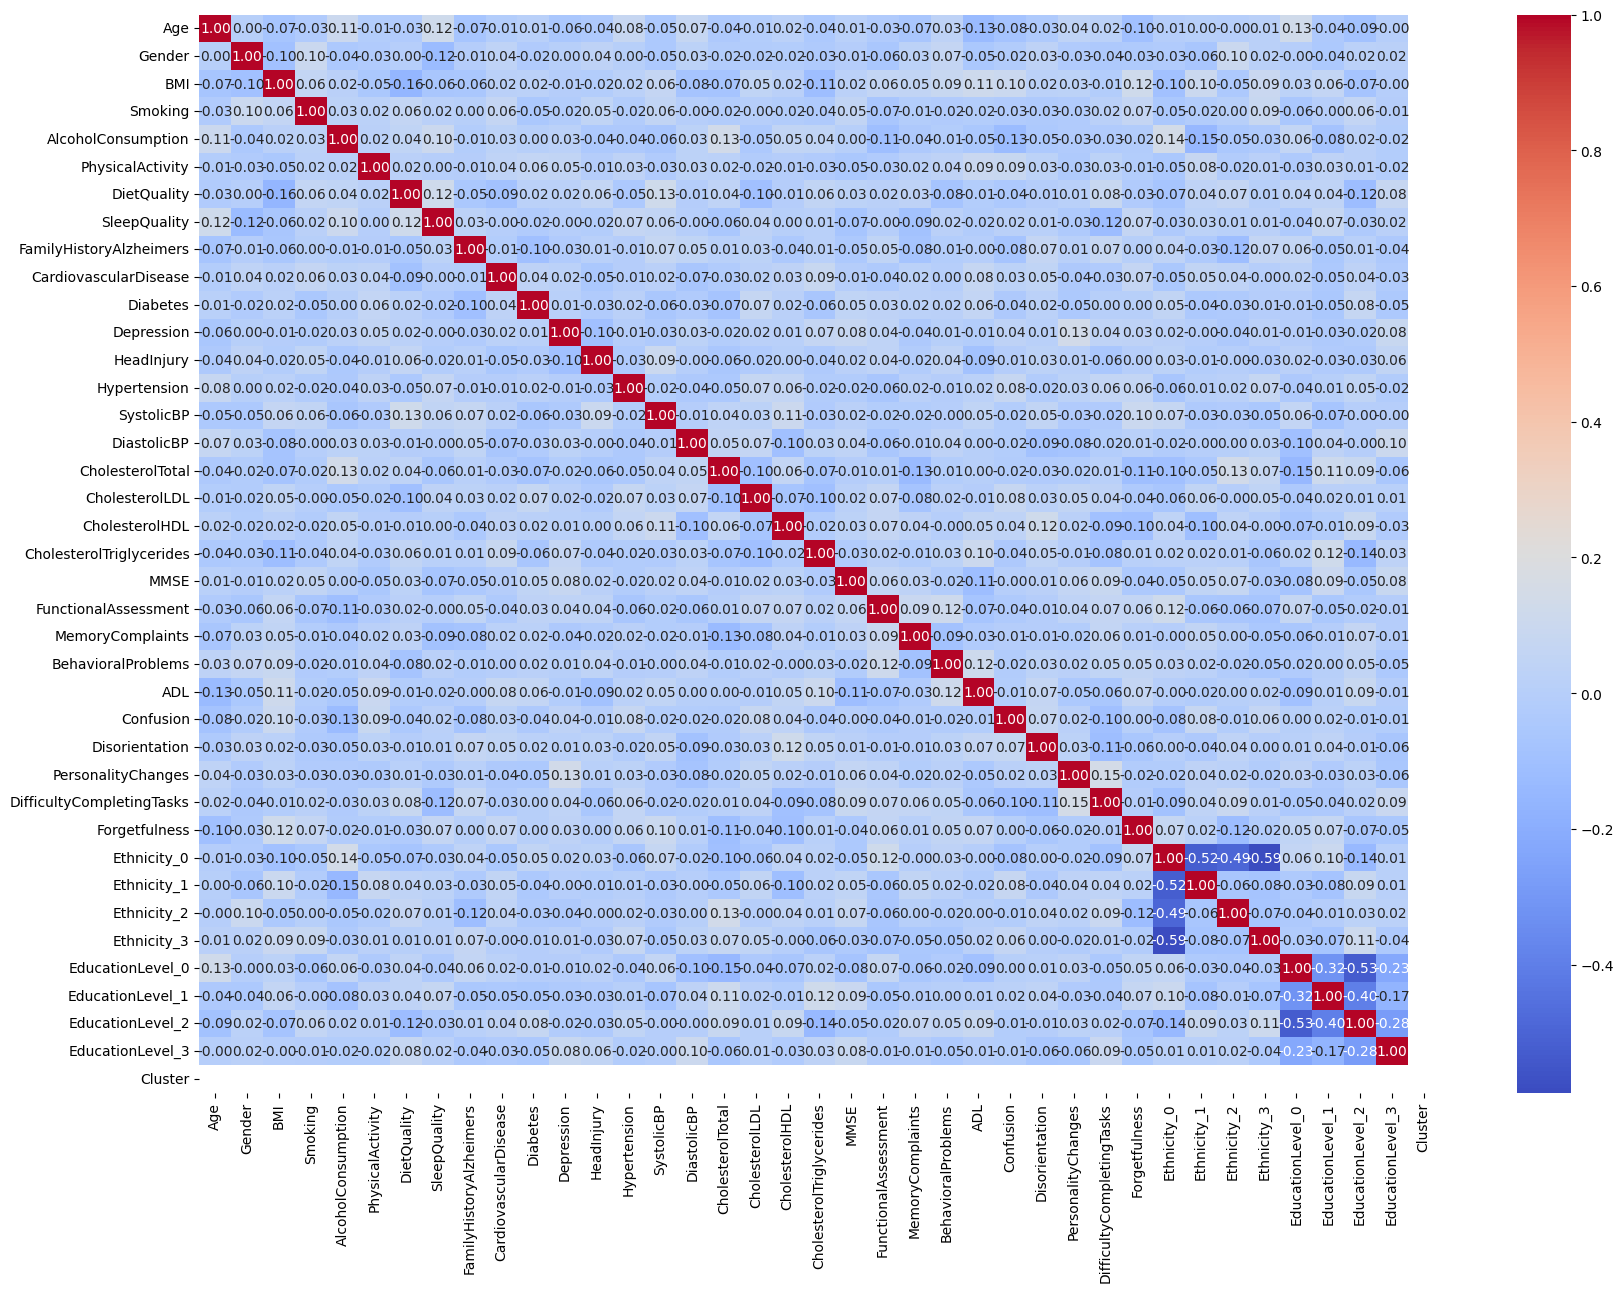

In [6]:
correlation_matrix = X_sample.corr(method="spearman")
plt.figure(figsize=(20, 14))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

In [7]:
correlation_matrix["CholesterolTotal"].sort_values(ascending=False)

CholesterolTotal             1.000000
Ethnicity_2                  0.134917
AlcoholConsumption           0.133437
EducationLevel_1             0.108478
EducationLevel_2             0.086252
Ethnicity_3                  0.074795
CholesterolHDL               0.058471
DiastolicBP                  0.052133
SystolicBP                   0.042686
DietQuality                  0.040244
PhysicalActivity             0.020426
FamilyHistoryAlzheimers      0.011377
DifficultyCompletingTasks    0.008087
FunctionalAssessment         0.006779
ADL                          0.001512
MMSE                        -0.005741
BehavioralProblems          -0.014107
Depression                  -0.015046
PersonalityChanges          -0.019222
Gender                      -0.020244
Smoking                     -0.022006
Confusion                   -0.022778
CardiovascularDisease       -0.025014
Disorientation              -0.029248
Age                         -0.041731
Hypertension                -0.045417
Ethnicity_1 

### Variabilidad desde mayor a menor (Solo para el cluster 0)
Aquellos con mayor variabilidad podrian ser candidatos

In [8]:
X_sample.var().sort_values(ascending=False)

PhysicalActivity             0.370923
CholesterolHDL               0.337382
DiastolicBP                  0.330965
CholesterolTriglycerides     0.328995
CholesterolLDL               0.324611
Age                          0.316753
SleepQuality                 0.298479
MMSE                         0.292184
SystolicBP                   0.289231
ADL                          0.287963
AlcoholConsumption           0.282043
DietQuality                  0.271661
BMI                          0.265346
FunctionalAssessment         0.265255
CholesterolTotal             0.265118
Gender                       0.250403
EducationLevel_2             0.240404
Forgetfulness                0.219307
Smoking                      0.215625
EducationLevel_0             0.209717
MemoryComplaints             0.196522
FamilyHistoryAlzheimers      0.190481
Depression                   0.164608
Confusion                    0.161616
Ethnicity_0                  0.158573
EducationLevel_1             0.157032
Cardiovascul

### Distribuciones

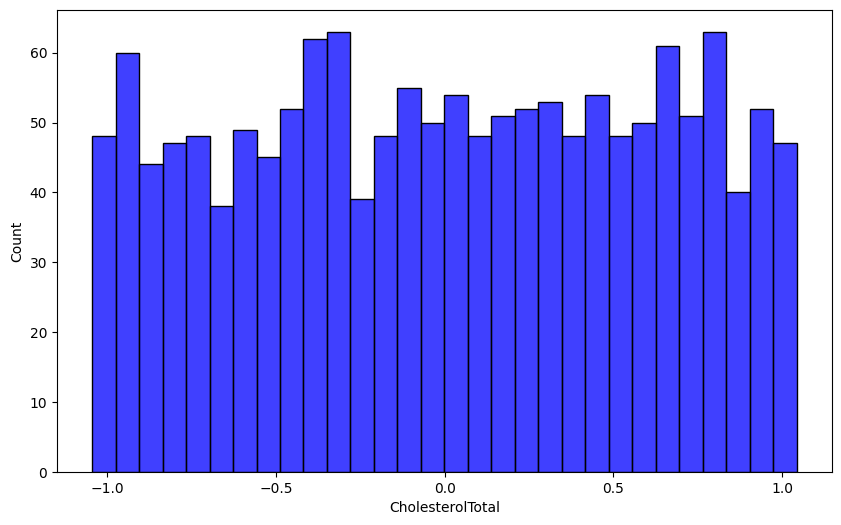

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(X['CholesterolTotal'], kde=False, bins=30, color='blue')
plt.xlabel('CholesterolTotal')
plt.ylabel('Count')
plt.show()


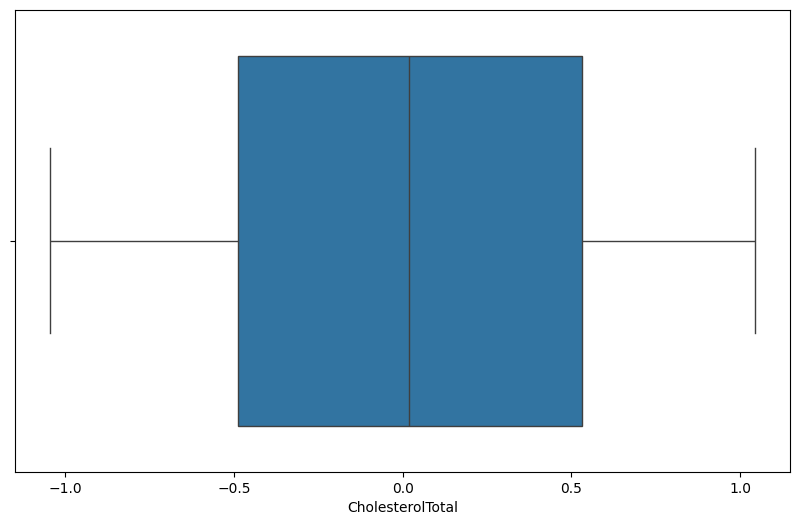

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=X['CholesterolTotal'])
plt.xlabel('CholesterolTotal')
plt.show()

### Data

In [11]:
regression_X = X_sample.drop(columns=['CholesterolTotal'])
regression_y = X_sample['CholesterolTotal']

X_train_val, X_test, y_train_val, y_test = train_test_split(regression_X, regression_y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

### Training

In [33]:
class RGNModels():
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.models = {
            "AdaBoost": AdaBoostRegressor(learning_rate=0.1, n_estimators=200, random_state=42),
            "RandomForest": RandomForestRegressor(random_state=42, max_features="sqrt", n_estimators=200),
            "SVM": SVR(kernel="linear", C=0.1, epsilon=0.5),
            "DecisionTree": DecisionTreeRegressor(max_depth=20, min_samples_split=10),
            "LGBM": LGBMRegressor(random_state=42),
            "XGBoost": XGBRegressor(random_state=42, learning_rate=0.01, n_estimators=50),
            "Lasso": Lasso(alpha=2.0),
            "Ridge": Ridge(alpha=5.0),
            "ElasticNet": ElasticNet(alpha=0.5, l1_ratio=0.1)
        }
    
    def train(self):
        for name, model in self.models.items():
            model.fit(self.X_train, self.y_train)
    
    def get_performances(self, X, y):
        performances = []
        for name, model in self.models.items():
            y_pred = model.predict(X)
            performances.append([
                name,
                root_mean_squared_error(y, y_pred),
                mean_absolute_error(y, y_pred),
                r2_score(y, y_pred)
            ])
        
        return pd.DataFrame(performances, columns=["Model", "RMSE", "MAE", "R2"])

    def plot_predictions(self, X, y_true, model_names):
        plt.figure(figsize=(10, 8))

        for model_name in model_names:
            y_pred = self.models[model_name].predict(X)
            sns.scatterplot(x=y_true, y=y_pred, alpha=0.5, label=model_name)

        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', lw=2)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.savefig("img/regression-predictions.png")
        plt.show()
    
    def run_halving_search(self, X, y, model_name):
        if model_name == "Lasso":
            param_grid = {
            "alpha": [0.1, 0.5, 1.0, 2.0, 5.0]
            }
        elif model_name == "Ridge":
            param_grid = {
            "alpha": [0.1, 0.5, 1.0, 2.0, 5.0]
            }
        elif model_name == "ElasticNet":
            param_grid = {
            "alpha": [0.1, 0.5, 1.0, 2.0, 5.0],
            "l1_ratio": [0.1, 0.5, 0.7, 1.0]
            }
        elif model_name == "AdaBoost":
            param_grid = {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
            }
        elif model_name == "RandomForest":
            param_grid = {
            "n_estimators": [50, 100, 200],
            "max_features": ["auto", "sqrt", "log2"]
            }
        elif model_name == "SVM":
            param_grid = {
            "C": [0.1, 1.0, 10.0],
            "epsilon": [0.1, 0.2, 0.5]
            }
        elif model_name == "DecisionTree":
            param_grid = {
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10]
            }
        elif model_name == "LGBM":
            param_grid = {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
            }
        elif model_name == "XGBoost":
            param_grid = {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
            }
        halving_search = HalvingGridSearchCV(self.models[model_name], param_grid, random_state=42)
        halving_search.fit(X, y)
        print(f"{model_name}: {halving_search.best_params_}")
    
    def run_shap(self, X, y, model_name, type="bar"):
        model = self.models[model_name]
        explainer = shap.Explainer(model)
        shap_values = explainer(X)
        shap.summary_plot(shap_values, X, plot_type=type)

    def run_shap_waterfall(self, X, y, model_name, index):
        model = self.models[model_name]
        explainer = shap.Explainer(model)
        shap_values = explainer(X)
        shap.plots.waterfall(shap_values[index])


In [34]:
rmodels_instance = RGNModels(X_train, y_train)
rmodels_instance.train()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1238
[LightGBM] [Info] Number of data points in the train set: 284, number of used features: 35
[LightGBM] [Info] Start training from score 0.251060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [35]:
for name, model in rmodels_instance.models.items():
    print(f"{name}: {model}")
    rmodels_instance.run_halving_search(X_train, y_train, name)

AdaBoost: AdaBoostRegressor(learning_rate=0.1, n_estimators=200, random_state=42)


KeyboardInterrupt: 

In [36]:
val_df = rmodels_instance.get_performances(X_val, y_val)

In [37]:
test_df = rmodels_instance.get_performances(X_test, y_test)

In [38]:
metrics_df = pd.merge(val_df, test_df, on="Model", suffixes=('_val', '_test'))
metrics_df['Overfitting'] = metrics_df['RMSE_test'] - metrics_df['RMSE_val']
metrics_df.sort_values(by=["RMSE_test", "MAE_test", "R2_test"], ascending=[True, True, False])

,Model,RMSE_val,MAE_val,R2_val,RMSE_test,MAE_test,R2_test,Overfitting
8,ElasticNet,0.497403,0.413442,-0.015516,0.533072,0.456440,-0.003630,0.035669
6,Lasso,0.497412,0.412753,-0.015554,0.533693,0.456830,-0.005968,0.036281
0,AdaBoost,0.478936,0.394502,0.058488,0.534115,0.452056,-0.007561,0.055179
5,XGBoost,0.494279,0.413774,-0.002801,0.537942,0.452995,-0.022050,0.043663
1,RandomForest,0.478973,0.399235,0.058345,0.546408,0.469757,-0.054476,0.067436
2,SVM,0.493888,0.409800,-0.001214,0.574615,0.504439,-0.166153,0.080727
4,LGBM,0.495450,0.402022,-0.007560,0.583683,0.482618,-0.203249,0.088232
7,Ridge,0.492944,0.407851,0.002607,0.595236,0.516424,-0.251355,0.102292
3,DecisionTree,0.595249,0.460302,-0.454349,0.649405,0.546437,-0.489474,0.054156


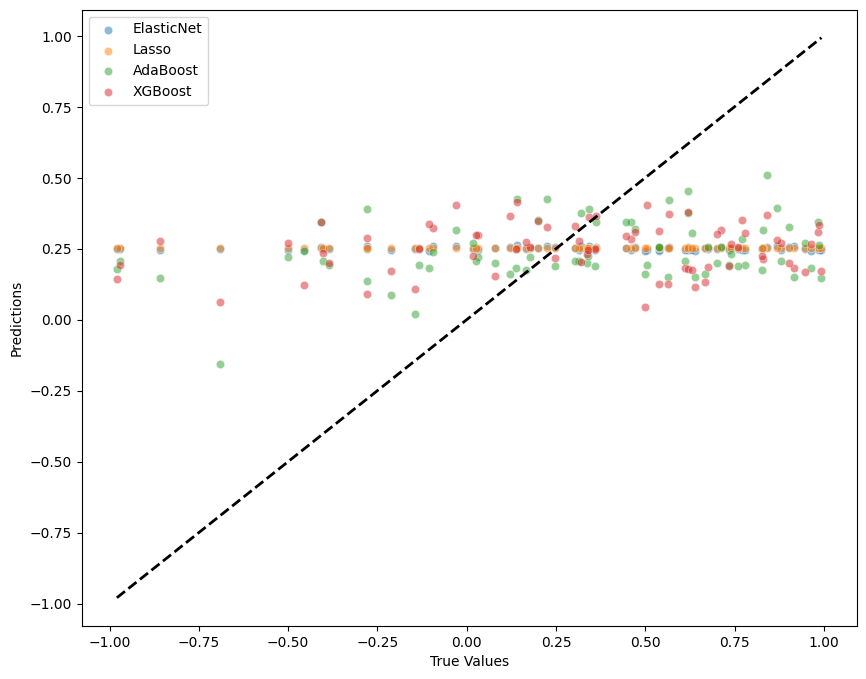

In [39]:
rmodels_instance.plot_predictions(X_val, y_val, ["ElasticNet", "Lasso", "AdaBoost", "XGBoost"])

## Shap

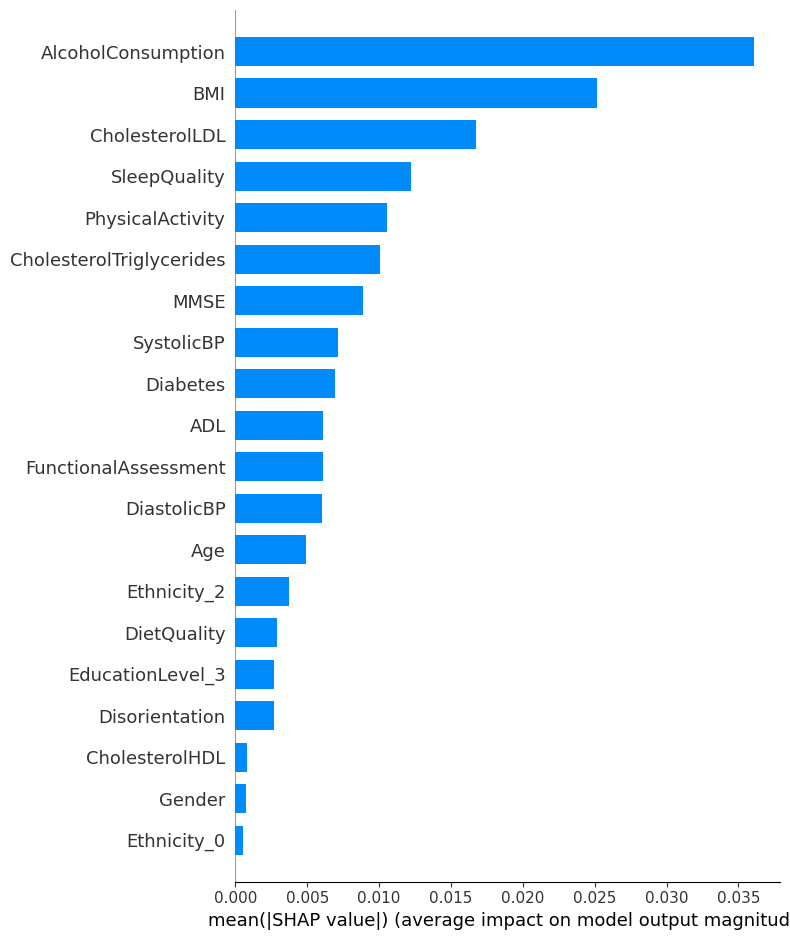

In [41]:
rmodels_instance.run_shap(X_val, y_val, "XGBoost")

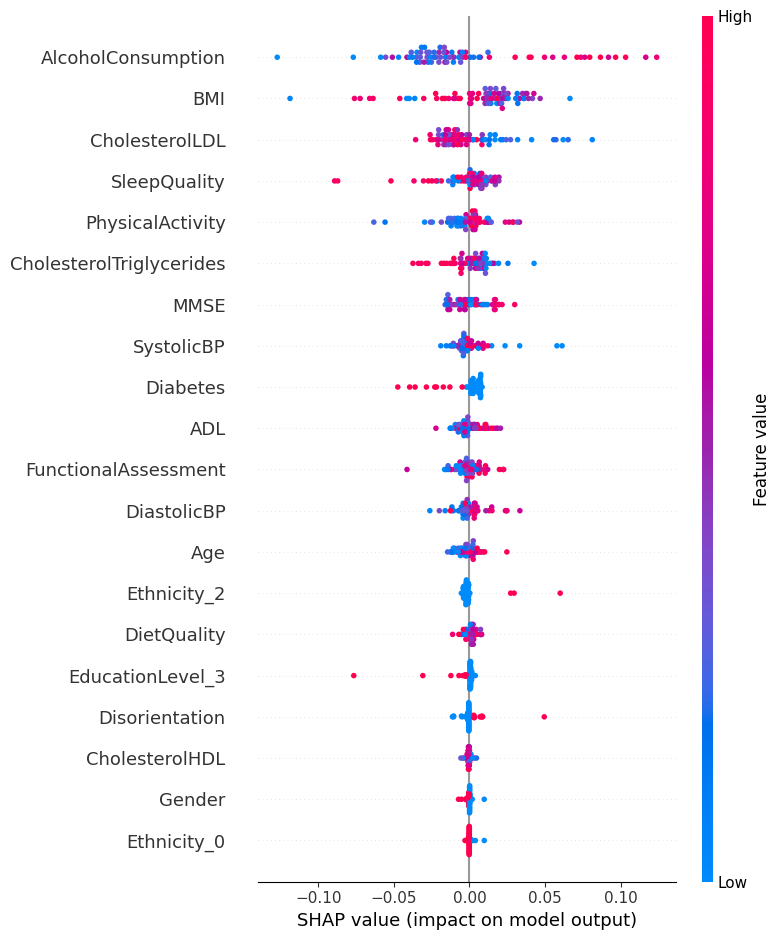

In [42]:
rmodels_instance.run_shap(X_val, y_val, "XGBoost", type="dot")

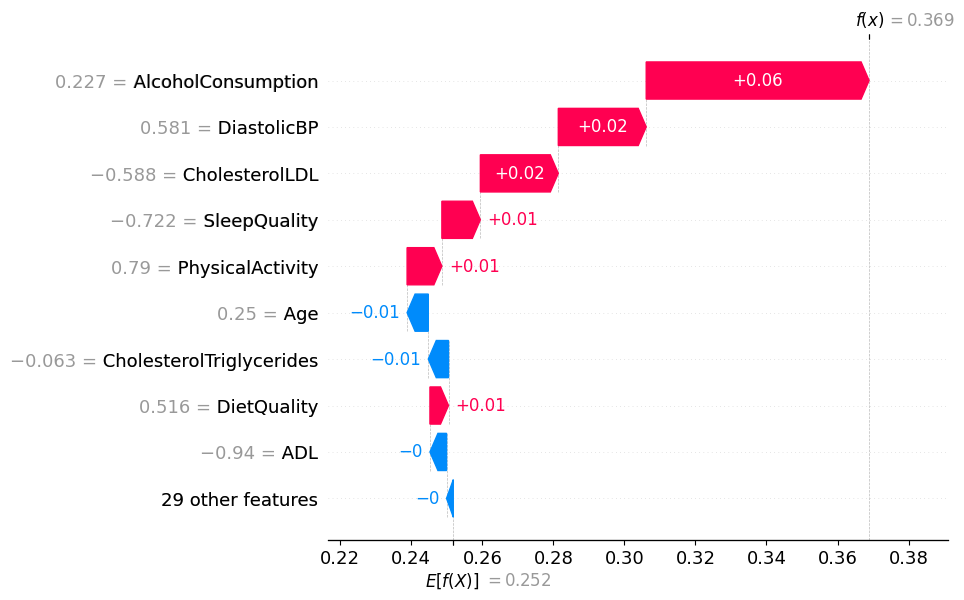

In [43]:
rmodels_instance.run_shap_waterfall(X_val, y_val, "XGBoost", 3)

## Counterfactual

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [173]:
def undersample(df, target_column):
    print(df.shape)
    print(f"Count of {target_column} 1:", df[df[target_column] == 1].shape[0])
    print(f"Count of {target_column} 0:", df[df[target_column] == 0].shape[0])
    df_positive = df[df[target_column] == 1]
    df_negative = df[df[target_column] == 0]

    if df_positive.shape[0] > df_negative.shape[0]:
        df_positive = df_positive.sample(df_negative.shape[0], random_state=42)
    else:
        df_negative = df_negative.sample(df_positive.shape[0], random_state=42)
    
    print(df.shape)
    print(f"Count of {target_column} 1:", df[df[target_column] == 1].shape[0])
    print(f"Count of {target_column} 0:", df[df[target_column] == 0].shape[0])
    
    export = pd.concat([df_positive, df_negative], axis=0).reset_index(drop=True)

    return export.drop(columns=[target_column]), export[target_column]

In [174]:
df = pd.read_csv("data/raw/alzheimers_disease_data.csv")
df.drop(columns=["PatientID", "DoctorInCharge"], inplace=True)
df

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,61,0,0,1,39.121757,0,1.561126,4.049964,6.555306,7.535540,...,0.238667,0,0,4.492838,1,0,0,0,0,1
2145,75,0,0,2,17.857903,0,18.767261,1.360667,2.904662,8.555256,...,8.687480,0,1,9.204952,0,0,0,0,0,1
2146,77,0,0,1,15.476479,0,4.594670,9.886002,8.120025,5.769464,...,1.972137,0,0,5.036334,0,0,0,0,0,1
2147,78,1,3,1,15.299911,0,8.674505,6.354282,1.263427,8.322874,...,5.173891,0,0,3.785399,0,0,0,0,1,1


In [175]:
X, y = undersample(df, 'Diagnosis')

(2149, 33)
Count of Diagnosis 1: 760
Count of Diagnosis 0: 1389
(2149, 33)
Count of Diagnosis 1: 760
Count of Diagnosis 0: 1389


In [178]:
df = pd.concat([X, labels], axis=1)
outcome_name = "Cluster"
df


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Cluster
0,75,0,0,1,18.776009,0,13.723826,4.649451,8.341903,4.213210,...,3.401374,0,0,4.517248,1,0,0,0,1,3
1,78,1,0,1,28.870652,1,10.194706,0.631281,1.653281,7.333236,...,4.510713,1,0,1.939596,0,1,0,0,0,2
2,69,0,0,1,18.045917,0,8.116832,2.956495,7.570633,6.736797,...,3.743028,0,0,1.911131,0,0,0,0,1,3
3,63,1,1,2,22.822896,1,4.433961,7.182895,7.929486,4.654828,...,9.365946,1,0,1.382086,0,0,0,0,0,1
4,65,1,0,1,16.333283,1,4.161795,1.306320,2.888936,5.436423,...,4.019546,0,0,2.892940,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,69,1,0,2,37.988682,0,5.412938,8.661141,8.263853,7.044154,...,7.810077,0,1,5.551866,0,0,0,0,0,0
1516,69,1,0,1,34.519868,0,19.078696,1.393494,7.963929,9.124304,...,0.503903,0,0,6.672147,1,0,0,0,0,2
1517,90,1,1,1,32.332727,0,7.068466,3.974726,0.366814,4.831716,...,9.646712,0,0,9.865888,0,0,1,0,0,2
1518,83,1,3,1,21.923466,0,0.198029,5.911030,3.290571,6.211040,...,7.429657,0,1,9.832045,1,0,0,0,1,2


In [179]:
continuous_features = df.drop(outcome_name, axis=1).columns.tolist()
target = df[outcome_name]
categorical_columns = df.select_dtypes(include=['object']).columns.tolist() + [col for col in df.select_dtypes(include=['int']).columns if df[col].nunique() < 5]
non_categorical_columns = [col for col in df.columns if col not in categorical_columns]


In [180]:
datasetX = df.drop(outcome_name, axis=1)
x_train, x_test, y_train, y_test = train_test_split(datasetX,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=target)


numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, non_categorical_columns),
        ('cat', categorical_transformer, ["Ethnicity", "EducationLevel"])])

clf = Pipeline(steps=[
    ('preprocessor', transformations),
    ('classifier', RandomForestClassifier())])
model= clf.fit(x_train, y_train)

In [181]:
d = dice_ml.Data(dataframe=df,
                      continuous_features=continuous_features,
                      outcome_name=outcome_name)

m = dice_ml.Model(model=model, backend="sklearn", model_type='classifier')

In [182]:
exp_genetic = dice_ml.Dice(d, m, method="genetic")

In [183]:
y_test

857     2
560     2
943     3
204     0
28      2
       ..
1396    0
952     2
346     0
90      0
653     3
Name: Cluster, Length: 304, dtype: int64

In [184]:
X_test.columns

Index(['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking',
       'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality',
       'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes',
       'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP',
       'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
       'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
       'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
       'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
       'Forgetfulness'],
      dtype='object')

In [189]:
# Single input
query_instances = x_test[204:205]
genetic = exp_genetic.generate_counterfactuals(query_instances, total_CFs=5, desired_class=0,
                                                        features_to_vary=["BMI", "Smoking", "AlcoholConsumption", "PhysicalActivity", "DietQuality", "SleepQuality", "Diabetes", "Depression", "SystolicBP", "DiastolicBP", "CholesterolTotal", "CholesterolLDL", "CholesterolHDL", "CholesterolTriglycerides", "MMSE", "FunctionalAssessment", "MemoryComplaints", "BehavioralProblems", "ADL", "Confusion", "Disorientation", "PersonalityChanges", "DifficultyCompletingTasks", "Forgetfulness"])
genetic.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

Query instance (original outcome : 3)


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Cluster
0,63,0,2,1,24.056795,1,14.059832,4.035925,5.377061,8.367678,...,3.154551,0,0,3.983063,0,0,0,1,0,3



Diverse Counterfactual set (new outcome: 0)


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Cluster
0,-,-,-,-,30.8649235,-,0.065285996,0.2208737433,6.329079151,6.6508732,...,2.8776977062,-,-,2.8630695343,-,-,-,-,-,0.0
0,-,-,-,-,31.6493473,-,0.065285996,0.2208737433,9.353616714,4.0026288,...,2.8776977062,-,-,0.0012879277,-,-,-,-,-,0.0
0,-,-,-,-,34.5723305,0.0,0.791787565,4.8935813904,7.759318829,8.6078672,...,2.2659361362,-,-,3.2160139084,-,-,-,-,-,0.0
0,-,-,-,-,38.7473297,-,11.149354935,0.9773122072,8.077713966,7.7057767,...,4.1720137596,-,-,1.9754428864,-,-,-,0.0,-,0.0
0,-,-,-,-,36.6021004,-,2.040101051,8.3366184235,7.931416035,6.2704396,...,1.1327154636,1.0,-,1.4270067215,-,-,-,-,-,0.0


In [187]:
# Multiple queries can be given as input at once
query_instances_iris = x_test[17:19]
genetic = exp_genetic.generate_counterfactuals(query_instances_iris, total_CFs=7, desired_class=3)
genetic.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

Query instance (original outcome : 2)


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Cluster
0,84,0,1,3,15.085793,0,4.505559,0.315982,1.578652,4.945214,...,8.898604,0,0,6.071792,0,0,0,0,1,2



Diverse Counterfactual set (new outcome: 3)


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Cluster
0,60.0,-,-,0.0,37.4100037,-,0.036260467,5.7037725449,0.00938472,4.0026288,...,0.0004595936,-,-,0.0012879277,-,-,-,-,-,3.0
0,60.0,-,0.0,0.0,15.0088511,-,0.036260467,0.0036160168,2.421231508,4.0026288,...,3.6725213528,-,-,0.0012879277,-,-,-,-,-,3.0
0,83.0,-,3.0,1.0,27.3898487,-,13.976290703,4.5918006897,8.228417397,4.3217888,...,9.2961912155,-,-,9.3870124817,-,-,-,-,-,3.0
0,60.0,-,0.0,0.0,15.0088511,-,19.688743591,0.0036160168,0.00938472,4.0026288,...,4.3794870377,-,-,0.2008982003,-,-,-,-,-,3.0
0,60.0,-,0.0,0.0,33.4746742,-,0.036260467,0.0036160168,0.00938472,4.0026288,...,3.6725213528,-,-,0.0012879277,-,-,-,-,0.0,3.0
0,60.0,-,0.0,0.0,15.0088511,-,0.036260467,0.0036160168,0.00938472,4.0026288,...,0.0004595936,-,-,0.0012879277,-,-,-,-,0.0,3.0
0,60.0,-,0.0,0.0,15.0088511,-,18.09016037,0.0036160168,0.00938472,4.0026288,...,0.0004595936,-,-,0.0012879277,-,-,-,-,0.0,3.0


Query instance (original outcome : 1)


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Cluster
0,80,1,3,2,23.715891,1,12.339372,5.970801,1.625098,8.944899,...,7.021783,0,0,2.744058,0,0,0,0,1,1



Diverse Counterfactual set (new outcome: 3)


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Cluster
0,87.0,-,2.0,-,31.4341183,0.0,15.961680412,6.7402200699,3.956887007,4.9117713,...,4.323972702,-,-,0.2222192585,-,-,-,-,-,3.0
0,65.0,-,-,0.0,28.4592781,-,9.857147217,4.8722658157,4.858956814,6.3093257,...,5.1026515961,-,-,6.0626792908,-,-,-,-,0.0,3.0
0,70.0,-,1.0,1.0,30.9361362,-,17.267381668,7.6675043106,3.76991725,5.4678736,...,4.9472465515,-,-,8.1818332672,-,-,-,-,0.0,3.0
0,75.0,-,-,1.0,20.6230373,-,5.959682941,9.8749752045,1.484482646,9.443387,...,1.1577193737,-,-,9.1169862747,-,-,-,-,0.0,3.0
0,60.0,-,-,1.0,15.0088511,-,9.857147217,7.2283806801,0.00938472,4.5512495,...,0.0004595936,1.0,-,0.0012879277,-,-,-,-,-,3.0
0,75.0,-,-,-,24.3530827,-,15.979701042,6.6058454514,5.476056576,6.4777479,...,3.8533811569,-,-,0.7187409997,-,-,-,-,0.0,3.0
0,75.0,-,-,0.0,30.9361362,-,17.267381668,0.0036160168,5.476056576,4.0026288,...,0.0004595936,-,-,0.7187409997,-,-,-,-,0.0,3.0
